# Classifiers using neuro-imaging data

In [13]:
import pandas as pd
import numpy as np
from numpy import random, arange
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, PolynomialFeatures, LabelEncoder

# Import relevant sklearn classes related to machine learning models
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, ElasticNet
from sklearn.svm import SVC, SVR, NuSVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier

# Import relevant sklearn class/function related to evaluation
import sklearn.metrics
from imblearn.under_sampling import RandomUnderSampler

#Smote oversampling 
import smote_variants as sv

## Data Pre-Processing

In [14]:

img_adni1 = pd.read_csv("../data/UCSFFSX51_ADNI1_3T_02_01_16.csv", low_memory=False)
img_adni2 = pd.read_csv("../data/UCSFFSX51_11_08_19.csv", low_memory=False)
img_adni3 = pd.read_csv("../data/UCSFFSX6_08_17_22.csv", low_memory=False)
adni_merge= pd.read_csv('../data/ADNIMERGE.csv', low_memory=False)


In [15]:

img_adni2.drop(["LONISID", "IMAGETYPE", "LHIPQC", "RHIPQC", "ST131HS", "ST132HS", "ST133HS", "ST134HS", "ST135HS", "ST136HS", "ST137HS", "ST138HS", "ST139HS", "ST140HS", "ST141HS", "ST142HS", "ST143HS", "ST144HS", "ST145HS", "ST146HS"], inplace=True, axis=1)
img_adni3.drop(["HIPPOQC"], axis=1, inplace=True)

In [16]:
colNames2 = []
for colName2 in img_adni2.columns:
    if not colName2 in img_adni1.columns:
        #print(colName2)
        if not (colName2 == "VISCODE2" or colName2 =="COLPROT"):
            colNames2.append(colName2)

print("---")
for colName3 in img_adni3.columns:
    if not colName3 in img_adni2.columns:
        print(colName3)
print("---")
colNames = []
for colName1 in img_adni1.columns:
    if not colName1 in img_adni2.columns:
        #print(colName1)
        colNames.append(colName1)


img_adni1.drop(colNames, inplace=True, axis=1)
img_adni2.drop(colNames2, inplace=True, axis=1)
img_adni3.drop(colNames2, axis=1, inplace=True)

---
---


In [31]:
dx = pd.read_csv("../data/DXSUM_PDXCONV_ADNIALL.csv", low_memory=False)
dx1= dx[(dx["Phase"] == "ADNI1")]
dx2= dx[(dx["Phase"] == "ADNI2") | (dx["Phase"] == "ADNIGO")]
dx3= dx[(dx["Phase"] == "ADNI3")]


6146

21

In [50]:
img_dx1 = pd.merge(img_adni1, dx1[["VISCODE", "RID", "DXCURREN", "EXAMDATE"]], left_on=["VISCODE","RID"], right_on=["VISCODE","RID"])
img_dx2go = pd.merge(img_adni2, dx2[["VISCODE2", "RID", "DXCHANGE", "Phase"]], left_on=["VISCODE2","RID", "COLPROT"], right_on=["VISCODE2","RID", "Phase"])
img_dx3 = pd.merge(img_adni3, dx3[["VISCODE2", "RID", "DIAGNOSIS", "Phase"]], left_on=["VISCODE2","RID", "COLPROT"], right_on=["VISCODE2","RID", "Phase"])

In [54]:
len(img_dx3)

1860

In [52]:
img_dx1.head()

,RID,VISCODE,EXAMDATE_x,VERSION,LONIUID,IMAGEUID,RUNDATE,STATUS,OVERALLQC,TEMPQC,...,ST149SV,ST150SV,ST151SV,ST152SV,ST153SV,ST154SV,ST155SV,update_stamp,DXCURREN,EXAMDATE_y
0,15,m36,2009-04-27,2013-08-07,66778,160866,2013-08-07,partial,Pass,Pass,...,366895,214481,215448.0,429929,167857,534752,909236,2016-02-02 09:34:17.0,1.0,2008-10-29
1,15,m06,2006-05-02,2013-08-07,13884,33041,2013-08-07,partial,Pass,Pass,...,375987,219660,218921.0,438581,171869,547856,931911,2016-02-02 09:34:17.0,1.0,2006-04-20
2,15,m24,2007-10-11,2013-08-07,41463,82551,2013-08-07,partial,Partial,Fail,...,375232,216223,216144.0,432367,168029,543261,923510,2016-02-02 09:34:17.0,1.0,2007-10-16
3,15,m12,2006-10-16,2013-08-07,20311,63475,2013-08-07,partial,Pass,Pass,...,375785,216942,214105.0,431047,172974,548759,921761,2016-02-02 09:34:17.0,1.0,2006-10-18
4,15,bl,2005-10-31,2013-08-07,8833,33046,2013-08-07,partial,Pass,Pass,...,382445,217061,216157.0,433218,167556,550001,928508,2016-02-02 09:34:17.0,1.0,2005-10-18


<AxesSubplot:xlabel='DXCURREN', ylabel='Probability'>

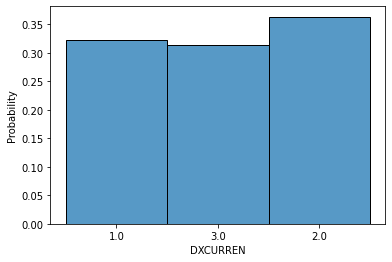

In [55]:

sns.histplot(img_dx1['DXCURREN'].astype(str), stat='probability')

<AxesSubplot:xlabel='DIAGNOSIS', ylabel='Probability'>

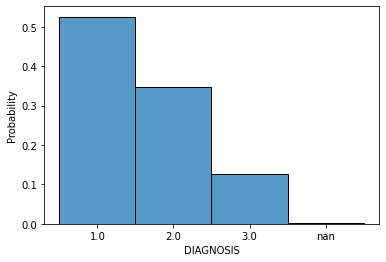

In [56]:
sns.histplot(img_dx3['DIAGNOSIS'].astype(str), stat='probability')

<AxesSubplot:xlabel='DXCHANGE', ylabel='Probability'>

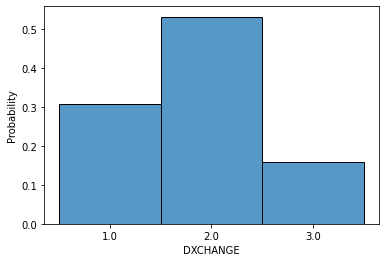

In [58]:
img2gocurren = img_dx2go.copy()
img2gocurren[(img2gocurren["DXCHANGE"] == 1) | (img2gocurren["DXCHANGE"] == 7) |(img2gocurren["DXCHANGE"] == 9)] = 1
img2gocurren[(img2gocurren["DXCHANGE"] == 2) | (img2gocurren["DXCHANGE"] == 4) |(img2gocurren["DXCHANGE"] == 8)] = 2
img2gocurren[(img2gocurren["DXCHANGE"] == 3) | (img2gocurren["DXCHANGE"] == 5) |(img2gocurren["DXCHANGE"] == 6)] = 3

sns.histplot(img2gocurren['DXCHANGE'].astype(str), stat='probability')

In [41]:
len(adni_merge)

16222